# View Examples of Word Segmentation Results

Copyright (c) 2021 Herman Kamper, MIT License

## Preliminaries

In [14]:
%matplotlib inline
from pathlib import Path
from scipy.spatial import distance
from tqdm import tqdm
import numpy as np
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import (
    boundaries_to_intervals, intervals_to_boundaries, score_boundaries, get_os, get_rvalue,
    get_intervals_from_dir
    )

## DPDP phone and word segmentation

### Read spectrograms, codes, segmentation (DPDP)

In [15]:
# Dataset
dataset = "buckeye"
split = "val"
model = "cpc_big"
phoneseg_tag = "phoneseg_dp_penalized"
# phoneseg_tag = "phoneseg_merge"
wordseg_tag = "wordseg_dpdp_aernn_dp_penalized"

# Utterances
utterances = [
#     "s22_02b_027666-027761",
#     "s17_01a_001056-001166",
    "s17_01a_005537-005624",
#     "s17_02a_013105-013792", # keep
#     "s37_02b_019498-019627",
#     "s19_02a_025961-026093", 
#     "s19_03a_054895-055029", 
#     "s40_01b_004705-004845", 
#     "s19_02a_026659-026808", 
#     "s19_02a_027075-027225", 
    "s34_01b_007955-008096", 
#     "s18_02b_006962-007103", 
#     "s19_02a_029147-029297", 
#     "s18_01b_004645-004790", 
#     "s22_02a_055965-056104", 
    ]

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"prequant"
phoneseg_dir = Path("../exp/")/model/dataset/split/phoneseg_tag/"intervals"
phoneref_dir = Path("fixed_phone_intervals") #Path("../data/")/dataset/"phone_intervals"
wordseg_dir = Path("../exp/")/model/dataset/split/wordseg_tag/"intervals"
wordref_dir = Path("fixed_word_intervals") #Path("../data/")/dataset/"word_intervals"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split

# # Temp
# utterances = [
#     "s17_01a_006274-006426",
#     "s18_01a_030448-030516",
#     "s18_01a_025953-026126",
#     "s19_01a_040032-040086",
# #     "s17_01a_025914-025985",
#     "s17_03a_039793-039855",
#     "s18_01a_020649-020878"
#     ]
# phoneref_dir = Path("../data/")/dataset/"phone_intervals"
# wordref_dir = Path("../data/")/dataset/"word_intervals"

# # Temp 2
# utterances = [
#     "s17_02b_013832-014392",
#     "s34_02a_012660-012984",
#     "s37_03b_018807-018979",
#     "s39_03b_017891-017956",
#     ]
# phoneref_dir = Path("../data/")/dataset/"phone_intervals"
# wordref_dir = Path("../data/")/dataset/"word_intervals"

In [16]:
# Read indices
indices_dict = {}
for utterance_key in sorted(utterances):
    indices_fn = (indices_dir/utterance_key).with_suffix(".txt")
    indices_dict[utterance_key] = np.asarray(np.loadtxt(indices_fn), dtype=int)

# Read pre-quantisation
z_dict = {}
for utterance_key in sorted(utterances):
    z_fn = (z_dir/utterance_key).with_suffix(".txt")
    z_dict[utterance_key] = np.loadtxt(z_fn)

# Audio
audio_dict = {}
for utterance_key in sorted(utterances):
    fn = (audio_dir/utterance_key.split("_")[0]/utterance_key).with_suffix(".mel.npy")
    audio_dict[utterance_key] = np.load(fn).T
    
# Read phone segmentation
phoneseg_interval_dict = {}
for utterance_key in sorted(utterances):
    phoneseg_interval_dict[utterance_key] = []
    fn = (phoneseg_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        label = int(label)
        phoneseg_interval_dict[utterance_key].append((start, end, label))
    
# Read phone reference
phoneref_interval_dict = {}
for utterance_key in sorted(utterances):
    phoneref_interval_dict[utterance_key] = []
    fn = (phoneref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        phoneref_interval_dict[utterance_key].append((start, end, label))

# Read word segmentation
wordseg_interval_dict = {}
for utterance_key in sorted(utterances):
    wordseg_interval_dict[utterance_key] = []
    fn = (wordseg_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
#         label = int(label)
        wordseg_interval_dict[utterance_key].append((start, end, label))

# Read word reference
wordref_interval_dict = {}
for utterance_key in sorted(utterances):
    wordref_interval_dict[utterance_key] = []
    fn = (wordref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        wordref_interval_dict[utterance_key].append((start, end, label))

In [17]:
phoneseg_interval_dict["s34_01b_007955-008096"][-1] = (136, 140, "9")  # instead of (136, 140, "9")

### Convert intervals to boundaries

In [18]:
# Phone
phoneseg_boundaries_dict = {}
for utterance_key in phoneseg_interval_dict:
    phoneseg_boundaries_dict[utterance_key] = intervals_to_boundaries(
        phoneseg_interval_dict[utterance_key]
        )
phoneref_boundaries_dict = {}
for utterance_key in phoneref_interval_dict:
    phoneref_boundaries_dict[utterance_key] = intervals_to_boundaries(
        phoneref_interval_dict[utterance_key]
        )

# Word
wordseg_boundaries_dict = {}
for utterance_key in wordseg_interval_dict:
    wordseg_boundaries_dict[utterance_key] = intervals_to_boundaries(
        wordseg_interval_dict[utterance_key]
        )
wordref_boundaries_dict = {}
for utterance_key in wordref_interval_dict:
    wordref_boundaries_dict[utterance_key] = intervals_to_boundaries(
        wordref_interval_dict[utterance_key]
        )

### Plot codes, reference, segmentation on top of spectrograms

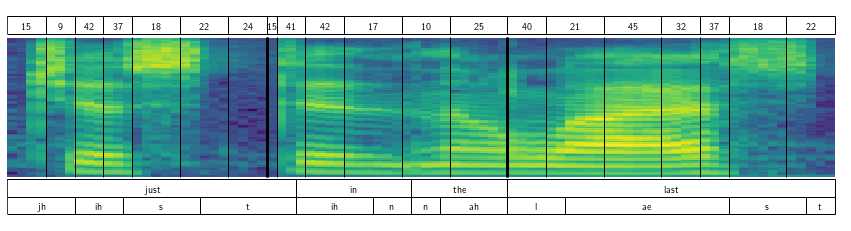

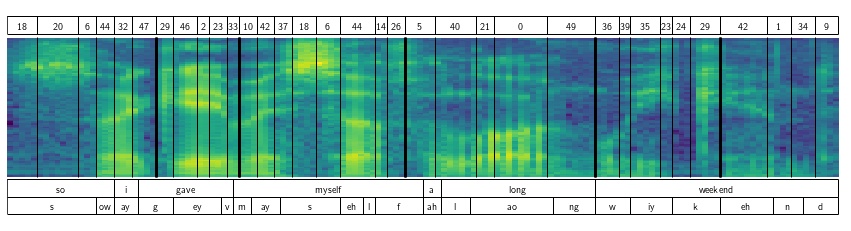

In [19]:
# utterance_key = utterances[1]
for utterance_key in utterances:
# for utterance_key in [utterances[0], utterances[-5]]:

    features = audio_dict[utterance_key].T
    indices = indices_dict[utterance_key]
    phones = phoneref_interval_dict[utterance_key]
    words = wordref_interval_dict[utterance_key]

    # Spectrogram
    plt.figure(figsize=(15, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")

    # Phone codes
    codes_bottom = features.shape[0] + 2
    codes_top = codes_bottom + 10
    for start, end, label in phoneseg_interval_dict[utterance_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, codes_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneseg_boundaries_dict[utterance_key])[0] + 0.5, ymin=codes_bottom, ymax=codes_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(codes_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.hlines(codes_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], codes_bottom, codes_top )
    
#     # Codes
#     for i in range(len(indices)):
#         plt.text(i + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)

    # Phone segmentation
    plt.vlines(
        np.where(phoneseg_boundaries_dict[utterance_key][:-1])[0] + 0.5,
        ymin=-0.5, ymax=features.shape[0], colors="k", lw=1
        )  # predicted boundaries

    # Word segmentation
    plt.vlines(
        np.where(wordseg_boundaries_dict[utterance_key][:-1])[0] + 0.5,
        ymin=-0.5, ymax=features.shape[0], colors="k", lw=3
        )  # predicted boundaries

    # Phone reference
    phone_bottom = -22
    phone_top = -12
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, phone_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneref_boundaries_dict[utterance_key])[0] + 0.5, ymin=phone_bottom, ymax=phone_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(phone_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    # plt.hlines(phone_bottom, -0.5, features.shape[1] + 0.5, colors="k", lw=1, linestyles="dashed")

    # Word reference
    word_bottom = -12
    word_top = -2
    for start, end, label in words:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, word_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(wordref_boundaries_dict[utterance_key])[0] + 0.5, ymin=word_bottom, ymax=word_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(word_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    
    plt.hlines(word_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], phone_bottom, word_top)

    plt.xlim([-0.5, features.shape[1] + 0.5])
    plt.axis("off")
    
#     plt.savefig("test.pdf")


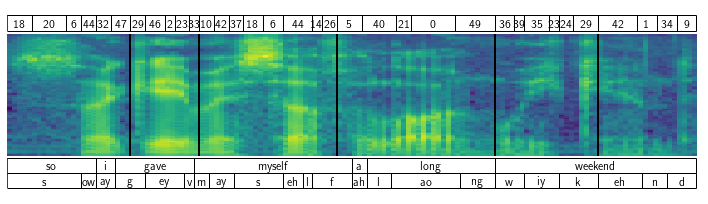

In [21]:
plt.rcParams["text.usetex"]             = True
plt.rcParams["font.size"]               = 12

# utterance_key = utterances[1]
for utterance_key in [utterances[-1], ]:
# for utterance_key in [utterances[0], utterances[-5]]:

    features = audio_dict[utterance_key].T
    indices = indices_dict[utterance_key]
    phones = phoneref_interval_dict[utterance_key]
    words = wordref_interval_dict[utterance_key]

    # Spectrogram
    fig = plt.figure(figsize=(10, 3))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")

    # Phone codes
    codes_bottom = features.shape[0] + 2
    codes_top = codes_bottom + 10
    for start, end, label in phoneseg_interval_dict[utterance_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, codes_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneseg_boundaries_dict[utterance_key])[0] + 0.5, ymin=codes_bottom, ymax=codes_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(codes_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.hlines(codes_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], codes_bottom, codes_top)
    
#     # Codes
#     for i in range(len(indices)):
#         plt.text(i + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)

#     # Phone segmentation
#     plt.vlines(
#         np.where(phoneseg_boundaries_dict[utterance_key][:-1])[0] + 0.5,
#         ymin=0, ymax=features.shape[0] - 0.5, colors="k", lw=1
#         )  # predicted boundaries

    # Word segmentation
    plt.vlines(
        np.where(wordseg_boundaries_dict[utterance_key][:-1])[0] + 0.5,
        ymin=-0.5, ymax=features.shape[0], colors="k", lw=2
        )  # predicted boundaries

    # Phone reference
    phone_bottom = -22
    phone_top = -12
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, phone_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneref_boundaries_dict[utterance_key])[0] + 0.5, ymin=phone_bottom, ymax=phone_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(phone_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    # plt.hlines(phone_bottom, -0.5, features.shape[1] + 0.5, colors="k", lw=1, linestyles="dashed")

    # Word reference
    word_bottom = -12
    word_top = -2
    for start, end, label in words:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, word_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(wordref_boundaries_dict[utterance_key])[0] + 0.5, ymin=word_bottom, ymax=word_top,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(word_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    
    plt.hlines(word_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], phone_bottom, word_top)

    plt.xlim([-0.5, features.shape[1] + 0.5])
    plt.axis("off")
#     ax = plt.gca()
#     ax.set_aspect("equal")
    fig.tight_layout()
    
    plt.savefig("so_i_gave_myself.pdf")


## CPC-big merge phone segmentation

### Read spectrograms, codes, segmentation (DPDP)

In [8]:
# Dataset
dataset = "buckeye"
split = "val"
model = "cpc_big"
# phoneseg_tag = "phoneseg_dp_penalized"
phoneseg_tag = "phoneseg_merge"

# Utterances
utterances = [
#     "s22_02b_027666-027761",
#     "s17_01a_001056-001166",
    "s17_01a_005537-005624",
#     "s17_02a_013105-013792", # keep
#     "s37_02b_019498-019627",
#     "s19_02a_025961-026093", 
#     "s19_03a_054895-055029", 
#     "s40_01b_004705-004845", 
#     "s19_02a_026659-026808", 
#     "s19_02a_027075-027225", 
    "s34_01b_007955-008096", 
#     "s18_02b_006962-007103", 
#     "s19_02a_029147-029297", 
#     "s18_01b_004645-004790", 
#     "s22_02a_055965-056104", 
]

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"prequant"
phoneseg_dir = Path("../exp/")/model/dataset/split/phoneseg_tag/"intervals"
phoneref_dir = Path("fixed_phone_intervals") #Path("../data/")/dataset/"phone_intervals"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split

In [9]:
# Read indices
indices_dict = {}
for utterance_key in sorted(utterances):
    indices_fn = (indices_dir/utterance_key).with_suffix(".txt")
    indices_dict[utterance_key] = np.asarray(np.loadtxt(indices_fn), dtype=int)

# Read pre-quantisation
z_dict = {}
for utterance_key in sorted(utterances):
    z_fn = (z_dir/utterance_key).with_suffix(".txt")
    z_dict[utterance_key] = np.loadtxt(z_fn)

# Audio
audio_dict = {}
for utterance_key in sorted(utterances):
    fn = (audio_dir/utterance_key.split("_")[0]/utterance_key).with_suffix(".mel.npy")
    audio_dict[utterance_key] = np.load(fn).T
    
# Read phone segmentation
phoneseg_interval_dict = {}
for utterance_key in sorted(utterances):
    phoneseg_interval_dict[utterance_key] = []
    fn = (phoneseg_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        label = int(label)
        phoneseg_interval_dict[utterance_key].append((start, end, label))
    
# Read phone reference
phoneref_interval_dict = {}
for utterance_key in sorted(utterances):
    phoneref_interval_dict[utterance_key] = []
    fn = (phoneref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        phoneref_interval_dict[utterance_key].append((start, end, label))

### Convert intervals to boundaries

In [10]:
# Phone
phoneseg_boundaries_dict = {}
for utterance_key in phoneseg_interval_dict:
    phoneseg_boundaries_dict[utterance_key] = intervals_to_boundaries(
        phoneseg_interval_dict[utterance_key]
        )
phoneref_boundaries_dict = {}
for utterance_key in phoneref_interval_dict:
    phoneref_boundaries_dict[utterance_key] = intervals_to_boundaries(
        phoneref_interval_dict[utterance_key]
        )

### Plot codes, reference, segmentation on top of spectrograms

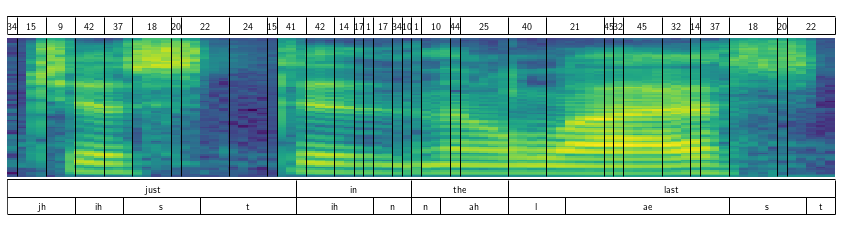

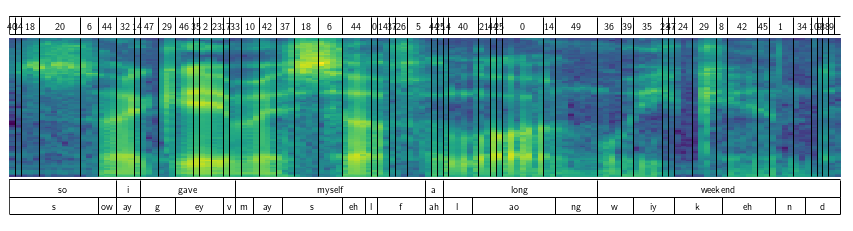

In [11]:
# utterance_key = utterances[1]
for utterance_key in utterances:
# for utterance_key in [utterances[0], utterances[-5]]:

    features = audio_dict[utterance_key].T
    indices = indices_dict[utterance_key]
    phones = phoneref_interval_dict[utterance_key]
    words = wordref_interval_dict[utterance_key]

    # Spectrogram
    plt.figure(figsize=(15, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")

    # Phone codes
    codes_bottom = features.shape[0] + 2
    codes_top = codes_bottom + 10
    for start, end, label in phoneseg_interval_dict[utterance_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, codes_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneseg_boundaries_dict[utterance_key])[0] + 0.5, ymin=codes_bottom, ymax=codes_top - 0.5,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(codes_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.hlines(codes_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], codes_bottom, codes_top)
    
#     # Codes
#     for i in range(len(indices)):
#         plt.text(i + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)

    # Phone segmentation
    plt.vlines(
        np.where(phoneseg_boundaries_dict[utterance_key][:-1])[0] + 0.5,
        ymin=0, ymax=features.shape[0] - 0.5, colors="k", lw=1
        )  # predicted boundaries

    # Phone reference
    phone_bottom = -22
    phone_top = -12
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, phone_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(phoneref_boundaries_dict[utterance_key])[0] + 0.5, ymin=phone_bottom, ymax=phone_top - 0.5,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(phone_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    # plt.hlines(phone_bottom, -0.5, features.shape[1] + 0.5, colors="k", lw=1, linestyles="dashed")

    # Word reference
    word_bottom = -12
    word_top = -2
    for start, end, label in words:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, word_bottom + 4, label, color="k", va="center", ha="center")
    plt.vlines(
        np.where(wordref_boundaries_dict[utterance_key])[0] + 0.5, ymin=word_bottom, ymax=word_top - 0.5,
        colors="k", lw=1
        )  # reference boundaries
    plt.hlines(word_bottom, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    
    plt.hlines(word_top, -0.5, features.shape[1] - 0.5, colors="k", lw=1)
    plt.vlines([-0.5, ], phone_bottom, word_top)

    plt.xlim([-0.5, features.shape[1] + 0.5])
    plt.axis("off")


## Duration analysis

In [12]:
 phoneseg_interval_dict = get_intervals_from_dir(phoneseg_dir)

 37%|███▋      | 6140/16582 [00:55<01:33, 111.61it/s]


KeyboardInterrupt: 

In [ ]:
n_frames = []
for utt_key in tqdm(sorted(phoneseg_interval_dict)):
    intervals = phoneseg_interval_dict[utt_key]
    n_utt_frames = 0
    for start, end, label in intervals:
        n_utt_frames += end - start
    n_frames.append(n_utt_frames)
#         n_frames.append(end - start)
print(f"Total duration: {np.sum(n_frames)/100/60/60:.2f} hours")
print(f"Max frames: {np.max(n_frames)}")
print(f"Max utterance: {sorted(phoneseg_interval_dict)[np.argmax(n_frames)]}")

In [ ]:
# for i in np.argpartition(n_frames, -4)[-1500:]:
#     if n_frames[i] < 150:
#         print(n_frames[i], i, sorted(phoneseg_interval_dict)[i])